In [2]:
%pip install emoji
%pip install spacy
!python -m spacy download es_core_news_sm


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 998.8 kB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [3]:
%pip install nltk
%pip install emoji
%pip install spacy
%pip install pandas
%pip install matplotlib
%pip install wordcloud



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 

In [4]:
import re
import json
import nltk
import emoji
import spacy
import subprocess
import numpy as np
import pandas as pd
from itertools import chain
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk import bigrams, trigrams
from nltk.tokenize import word_tokenize
%matplotlib inline

In [5]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download("wordnet")
nlp = spacy.load('es_core_news_sm')

[nltk_data] Downloading package punkt to /Users/stefanos2/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stefanos2/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/stefanos2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
# Comando curl
curl_command = """
curl -X GET "https://datasets-server.huggingface.co/rows?dataset=pysentimiento%2Fspanish-tweets&config=default&split=train&offset=0&length=100"
"""

# Ejecutar el comando curl
result = subprocess.run(curl_command, shell=True, capture_output=True, text=True)

# Convertir el resultado a un string (suponiendo que el output es JSON)
data_json = json.loads(result.stdout)

In [7]:
# se convierte la estructura json a dataframe
texts = []
for i in data_json['rows']:
    texts.append(i['row']['text'])

texts_df = pd.DataFrame(texts, columns=['tuits'])
texts_df

,tuits
0,@Liz_Mile Y después dices que no eres fan... h...
1,@Liz_Mile @Yaniserrano @ChasKapop Jajajaja si ...
2,Hay que tener pulso nivel 500 para darle con e...
3,@Liz_Mile Otro chino mas?!!!!! https://t.co/Ls...
4,@Yaniserrano Más extensiones 🤣
...,...
95,Sera que se tomaron la foto alli cuando los ch...
96,"Fluir bien, hacer las cosas lo mejor que se pu..."
97,No les enseñaron que lo mínimo es saludar y da...
98,Dice que me superó pero crea perfiles falsos e...


In [8]:
print(texts_df.tuits)

0     @Liz_Mile Y después dices que no eres fan... h...
1     @Liz_Mile @Yaniserrano @ChasKapop Jajajaja si ...
2     Hay que tener pulso nivel 500 para darle con e...
3     @Liz_Mile Otro chino mas?!!!!! https://t.co/Ls...
4                        @Yaniserrano Más extensiones 🤣
                            ...                        
95    Sera que se tomaron la foto alli cuando los ch...
96    Fluir bien, hacer las cosas lo mejor que se pu...
97    No les enseñaron que lo mínimo es saludar y da...
98    Dice que me superó pero crea perfiles falsos e...
99                              https://t.co/NroMRMZeXb
Name: tuits, Length: 100, dtype: object


#### 1. Limpieza de tuits

A cada tuit de manera independiente aplique las siguientes etapas de limpieza (crear una nueva columna llamada `cleaned_tuits`):

* Convertir a minisculas todas las letras.
* Remover Urls del texto.
* Remover usuarios (@) y hashtags (#).
* Remover caracteres repetidos más de 2 veces.
* Remover todos los emojis.
* Remover spacios en blanco adicionales (a los lados).

In [9]:
import re

# Convertir a minúsculas todas las letras
texts_df['cleaned_tuits'] = texts_df['tuits'].str.lower()

# Función para remover URLs del texto
def remover_urls(texto):
    return re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))', '', texto)

# Aplicar la función para remover URLs
texts_df['cleaned_tuits'] = texts_df['cleaned_tuits'].apply(remover_urls)

# Función para remover usuarios de Twitter
def remover_usuarios_hashtags(texto):
    return re.sub(r'@\w+', '', texto)

# Aplicar la función para remover usuarios y hashtags
texts_df['cleaned_tuits'] = texts_df['cleaned_tuits'].apply(remover_usuarios_hashtags)

# Función para remover caracteres repetidos más de 2 veces
def remover_caracteres_repetidos(texto):
    return re.sub(r'(.)\1{2,}', r'\1\1', texto)

# Aplicar la función para remover caracteres repetidos
texts_df['cleaned_tuits'] = texts_df['cleaned_tuits'].apply(remover_caracteres_repetidos)

# Función para remover emojis
def remover_emojis(texto):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', texto)

# Aplicar la función para remover emojis
texts_df['cleaned_tuits'] = texts_df['cleaned_tuits'].apply(remover_emojis)

# Remover espacios en blanco adicionales
texts_df['cleaned_tuits'] = texts_df['cleaned_tuits'].str.strip()

# Mostrar el DataFrame resultante
texts_df


,tuits,cleaned_tuits
0,@Liz_Mile Y después dices que no eres fan... h...,y después dices que no eres fan..
1,@Liz_Mile @Yaniserrano @ChasKapop Jajajaja si ...,jajajaja si se deja crecer el cabello estaría ...
2,Hay que tener pulso nivel 500 para darle con e...,hay que tener pulso nivel 500 para darle con e...
3,@Liz_Mile Otro chino mas?!!!!! https://t.co/Ls...,otro chino mas?!!
4,@Yaniserrano Más extensiones 🤣,más extensiones
...,...,...
95,Sera que se tomaron la foto alli cuando los ch...,sera que se tomaron la foto alli cuando los ch...
96,"Fluir bien, hacer las cosas lo mejor que se pu...","fluir bien, hacer las cosas lo mejor que se pu..."
97,No les enseñaron que lo mínimo es saludar y da...,no les enseñaron que lo mínimo es saludar y da...
98,Dice que me superó pero crea perfiles falsos e...,dice que me superó pero crea perfiles falsos e...


#### 2. Word tokenizer o TweetTokenizer

Divida tuit limpio en word tokens usando la librería word_tokenize o TweetTokenizer y guarde el resultado en una nueva columna llamada `tokens`.

¿Cuántos tokens únicos hay usando todos los tuits?

In [10]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
# Crear una nueva columna llamada 'tokens' para almacenar los tokens
texts_df['tokens'] = texts_df['cleaned_tuits'].apply(tokenizer.tokenize)
# Contar el número de tokens únicos usando todos los tuits
unique_tokens = set()
for tokens_list in texts_df['tokens']:
    unique_tokens.update(tokens_list)

num_unique_tokens = len(unique_tokens)
print("Número de tokens únicos:", num_unique_tokens)
# Mostrar el DataFrame resultante
texts_df

Número de tokens únicos: 599


,tuits,cleaned_tuits,tokens
0,@Liz_Mile Y después dices que no eres fan... h...,y después dices que no eres fan..,"[y, después, dices, que, no, eres, fan, ..]"
1,@Liz_Mile @Yaniserrano @ChasKapop Jajajaja si ...,jajajaja si se deja crecer el cabello estaría ...,"[jajajaja, si, se, deja, crecer, el, cabello, ..."
2,Hay que tener pulso nivel 500 para darle con e...,hay que tener pulso nivel 500 para darle con e...,"[hay, que, tener, pulso, nivel, 500, para, dar..."
3,@Liz_Mile Otro chino mas?!!!!! https://t.co/Ls...,otro chino mas?!!,"[otro, chino, mas, ?, !, !]"
4,@Yaniserrano Más extensiones 🤣,más extensiones,"[más, extensiones]"
...,...,...,...
95,Sera que se tomaron la foto alli cuando los ch...,sera que se tomaron la foto alli cuando los ch...,"[sera, que, se, tomaron, la, foto, alli, cuand..."
96,"Fluir bien, hacer las cosas lo mejor que se pu...","fluir bien, hacer las cosas lo mejor que se pu...","[fluir, bien, ,, hacer, las, cosas, lo, mejor,..."
97,No les enseñaron que lo mínimo es saludar y da...,no les enseñaron que lo mínimo es saludar y da...,"[no, les, enseñaron, que, lo, mínimo, es, salu..."
98,Dice que me superó pero crea perfiles falsos e...,dice que me superó pero crea perfiles falsos e...,"[dice, que, me, superó, pero, crea, perfiles, ..."


Calcule la frecuencia de los tokens usando la función `nltk.FreqDist` y gráfique los 50 primeros.

In [11]:
from nltk import FreqDist

In [12]:
#concatenamos todos los tokens de todos los tuits en una lista:
all_tokens = [token for tokens_list in texts_df['tokens'] for token in tokens_list]
#creamos una instancia de FreqDist con esta lista de tokens:
freq_dist = FreqDist(all_tokens)


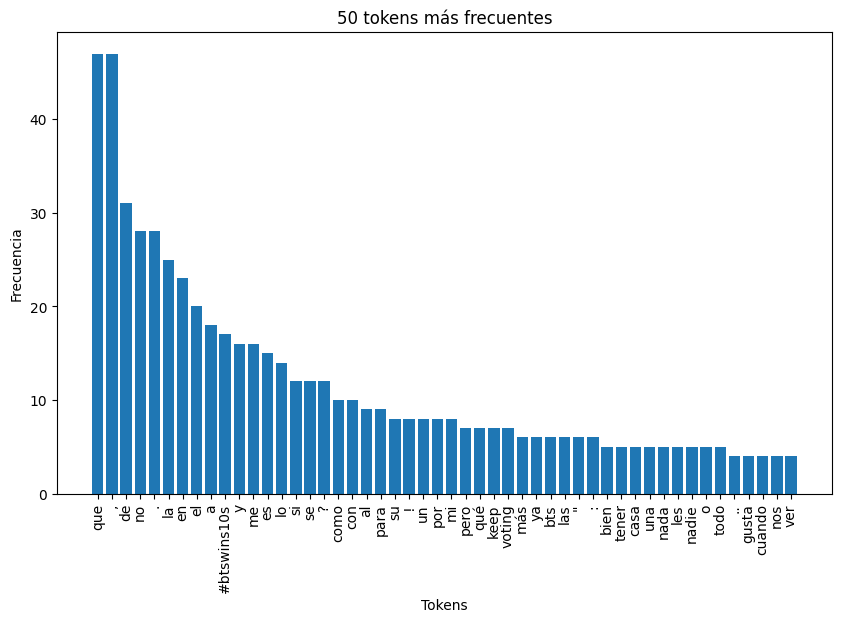

In [13]:
# Obtener los 50 tokens más frecuentes
top_50_tokens = freq_dist.most_common(50)

# Extraer las etiquetas (tokens) y las frecuencias
tokens, frequencies = zip(*top_50_tokens)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(tokens, frequencies)
plt.xticks(rotation=90)
plt.xlabel('Tokens')
plt.ylabel('Frecuencia')
plt.title('50 tokens más frecuentes')
plt.show()


#### 3. Elimine las stop words en español.

Elimine las stop words en español (mantenga la palabra no) y guardelas en una nueva columna llamada `cleaned_tokens`.

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stefanos2/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
from nltk.corpus import stopwords

# Obtener la lista de stopwords en español
stop_words_es = set(stopwords.words('spanish'))

# Función para eliminar las stopwords, excepto 'no'
def remover_stopwords(tokens):
    return [token for token in tokens if token.lower() not in stop_words_es or token.lower() == 'no']

# Aplicar la función a la columna 'tokens' y guardar los resultados en 'cleaned_tokens'
texts_df['cleaned_tokens'] = texts_df['tokens'].apply(remover_stopwords)

# Concatenar todos los tokens limpios en una sola lista
all_cleaned_tokens = [token for tokens_list in texts_df['cleaned_tokens'] for token in tokens_list]

# Calcular el número de tokens únicos
num_unique_tokens_cleaned = len(set(all_cleaned_tokens))

print("Número de tokens únicos después de eliminar las stopwords:", num_unique_tokens_cleaned)

# Mostrar el DataFrame resultante
texts_df


Número de tokens únicos después de eliminar las stopwords: 514


,tuits,cleaned_tuits,tokens,cleaned_tokens
0,@Liz_Mile Y después dices que no eres fan... h...,y después dices que no eres fan..,"[y, después, dices, que, no, eres, fan, ..]","[después, dices, no, fan, ..]"
1,@Liz_Mile @Yaniserrano @ChasKapop Jajajaja si ...,jajajaja si se deja crecer el cabello estaría ...,"[jajajaja, si, se, deja, crecer, el, cabello, ...","[jajajaja, si, deja, crecer, cabello, bien, gu..."
2,Hay que tener pulso nivel 500 para darle con e...,hay que tener pulso nivel 500 para darle con e...,"[hay, que, tener, pulso, nivel, 500, para, dar...","[tener, pulso, nivel, 500, darle, exactitud, ,..."
3,@Liz_Mile Otro chino mas?!!!!! https://t.co/Ls...,otro chino mas?!!,"[otro, chino, mas, ?, !, !]","[chino, mas, ?, !, !]"
4,@Yaniserrano Más extensiones 🤣,más extensiones,"[más, extensiones]",[extensiones]
...,...,...,...,...
95,Sera que se tomaron la foto alli cuando los ch...,sera que se tomaron la foto alli cuando los ch...,"[sera, que, se, tomaron, la, foto, alli, cuand...","[sera, tomaron, foto, alli, chicos, grabando, ..."
96,"Fluir bien, hacer las cosas lo mejor que se pu...","fluir bien, hacer las cosas lo mejor que se pu...","[fluir, bien, ,, hacer, las, cosas, lo, mejor,...","[fluir, bien, ,, hacer, cosas, mejor, pueda, h..."
97,No les enseñaron que lo mínimo es saludar y da...,no les enseñaron que lo mínimo es saludar y da...,"[no, les, enseñaron, que, lo, mínimo, es, salu...","[no, enseñaron, mínimo, saludar, dar, gracias,..."
98,Dice que me superó pero crea perfiles falsos e...,dice que me superó pero crea perfiles falsos e...,"[dice, que, me, superó, pero, crea, perfiles, ...","[dice, superó, crea, perfiles, falsos, grindr,..."


De manera similar al anterior grafico, Calcule la frecuencia de los tokens sin las stop words usando la función `nltk.FreqDist` y gráfique los 50 primeros. ¿Qué diferencias logra encontrar con respecto al anterior gráfico?

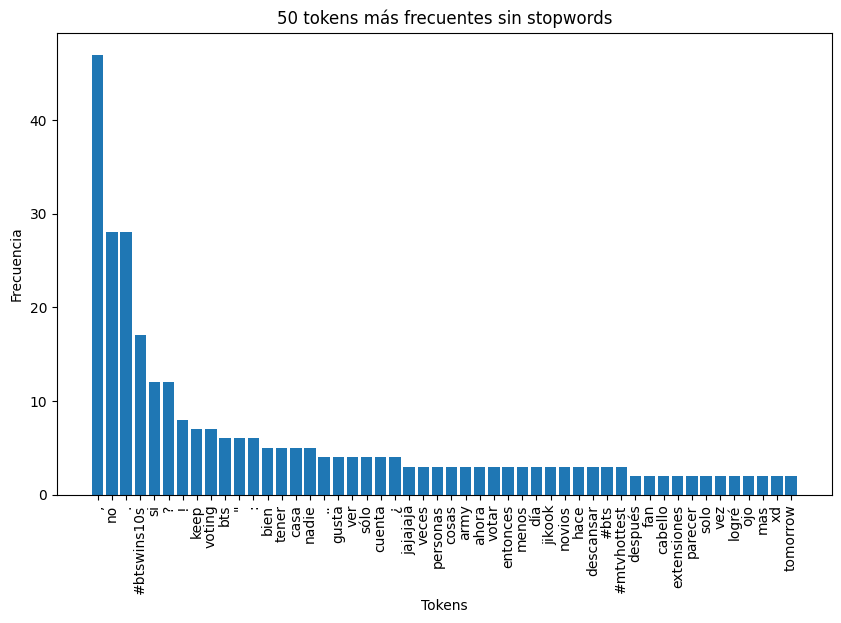

In [16]:
# Calcular la frecuencia de los tokens sin las stopwords
freq_dist_without_stopwords = FreqDist(all_cleaned_tokens)

# Obtener los 50 tokens más frecuentes sin las stopwords
top_50_tokens_without_stopwords = freq_dist_without_stopwords.most_common(50)

# Extraer las etiquetas (tokens) y las frecuencias
tokens_without_stopwords, frequencies_without_stopwords = zip(*top_50_tokens_without_stopwords)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(tokens_without_stopwords, frequencies_without_stopwords)
plt.xticks(rotation=90)
plt.xlabel('Tokens')
plt.ylabel('Frecuencia')
plt.title('50 tokens más frecuentes sin stopwords')
plt.show()

#### 4. Lematización

Use el lematizador de la librería `spacy` para lematizar los tokens guardados en la columna `cleaned_tokens` y guardelos en una nueva columna llamada `lemmatize_tokens`.

In [17]:
import spacy.cli

# Descargar el modelo 'es_core_news_sm' utilizando spacy.cli.download
spacy.cli.download("es_core_news_sm")

# Ahora intenta cargar el modelo
nlp = spacy.load('es_core_news_sm')

# Cargar el modelo de lenguaje de spaCy para español
nlp = spacy.load('es_core_news_sm')


  Using cached https://github.com/explosion/spacy-models/releases/download/es_core_news_sm-3.7.0/es_core_news_sm-3.7.0-py3-none-any.whl (12.9 MB)



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [18]:
# Función para lematizar los tokens
def lemmatize_tokens(tokens):
    lemmatized_tokens = []
    for token in tokens:
        doc = nlp(token)
        # Obtener el lema del token y agregarlo a la lista de tokens lematizados
        lemmatized_tokens.append(doc[0].lemma_)
    return lemmatized_tokens

# Aplicar la función a la columna 'cleaned_tokens' y guardar los resultados en 'lemmatized_tokens'
texts_df['lemmatized_tokens'] = texts_df['cleaned_tokens'].apply(lemmatize_tokens)

# Concatenar todos los tokens lematizados en una sola lista
all_lemmatized_tokens = [token for tokens_list in texts_df['lemmatized_tokens'] for token in tokens_list]

# Calcular el número de tokens lematizados únicos
num_unique_lemmatized_tokens = len(set(all_lemmatized_tokens))

print("Número de tokens lematizados únicos:", num_unique_lemmatized_tokens)
# Mostrar el DataFrame resultante
texts_df

Número de tokens lematizados únicos: 452


,tuits,cleaned_tuits,tokens,cleaned_tokens,lemmatized_tokens
0,@Liz_Mile Y después dices que no eres fan... h...,y después dices que no eres fan..,"[y, después, dices, que, no, eres, fan, ..]","[después, dices, no, fan, ..]","[después, diz, no, fan, ..]"
1,@Liz_Mile @Yaniserrano @ChasKapop Jajajaja si ...,jajajaja si se deja crecer el cabello estaría ...,"[jajajaja, si, se, deja, crecer, el, cabello, ...","[jajajaja, si, deja, crecer, cabello, bien, gu...","[jajajajar, si, dejar, crecer, cabello, bien, ..."
2,Hay que tener pulso nivel 500 para darle con e...,hay que tener pulso nivel 500 para darle con e...,"[hay, que, tener, pulso, nivel, 500, para, dar...","[tener, pulso, nivel, 500, darle, exactitud, ,...","[tener, pulso, nivel, 500, dar él, exactitud, ..."
3,@Liz_Mile Otro chino mas?!!!!! https://t.co/Ls...,otro chino mas?!!,"[otro, chino, mas, ?, !, !]","[chino, mas, ?, !, !]","[chino, mas, ?, !, !]"
4,@Yaniserrano Más extensiones 🤣,más extensiones,"[más, extensiones]",[extensiones],[extensión]
...,...,...,...,...,...
95,Sera que se tomaron la foto alli cuando los ch...,sera que se tomaron la foto alli cuando los ch...,"[sera, que, se, tomaron, la, foto, alli, cuand...","[sera, tomaron, foto, alli, chicos, grabando, ...","[sero, tomar, foto, alli, chico, grabar, progr..."
96,"Fluir bien, hacer las cosas lo mejor que se pu...","fluir bien, hacer las cosas lo mejor que se pu...","[fluir, bien, ,, hacer, las, cosas, lo, mejor,...","[fluir, bien, ,, hacer, cosas, mejor, pueda, h...","[fluir, bien, ,, hacer, cosa, mejor, poder, ha..."
97,No les enseñaron que lo mínimo es saludar y da...,no les enseñaron que lo mínimo es saludar y da...,"[no, les, enseñaron, que, lo, mínimo, es, salu...","[no, enseñaron, mínimo, saludar, dar, gracias,...","[no, enseñar, mínimo, saludar, dar, gracias, ?..."
98,Dice que me superó pero crea perfiles falsos e...,dice que me superó pero crea perfiles falsos e...,"[dice, que, me, superó, pero, crea, perfiles, ...","[dice, superó, crea, perfiles, falsos, grindr,...","[decir, superar, creer, perfil, falso, grindr,..."


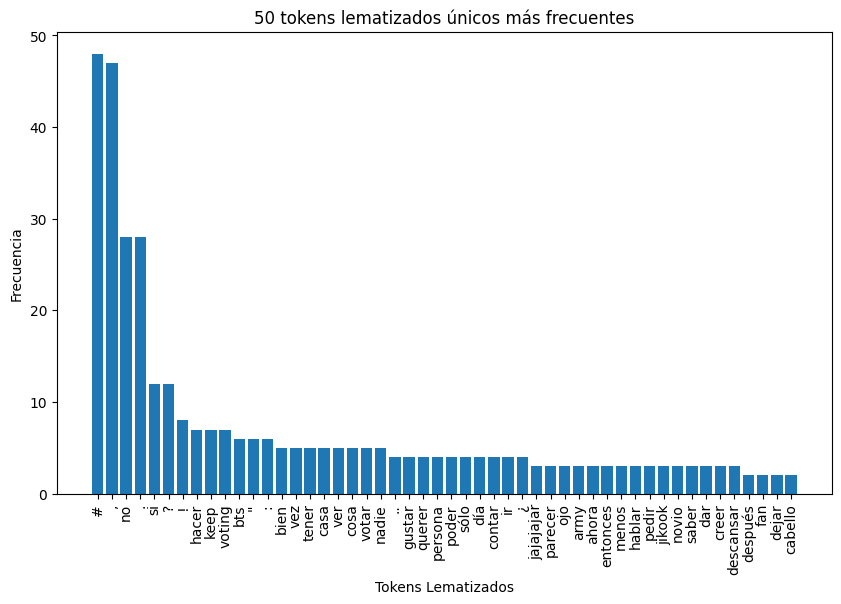

In [19]:
# Calcular la frecuencia de los tokens lematizados únicos
freq_dist_lemmatized = FreqDist(all_lemmatized_tokens)

# Obtener los 50 tokens lematizados más frecuentes
top_50_lemmatized_tokens = freq_dist_lemmatized.most_common(50)

# Extraer las etiquetas (tokens) y las frecuencias
tokens_lemmatized, frequencies_lemmatized = zip(*top_50_lemmatized_tokens)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(tokens_lemmatized, frequencies_lemmatized)
plt.xticks(rotation=90)
plt.xlabel('Tokens Lematizados')
plt.ylabel('Frecuencia')
plt.title('50 tokens lematizados únicos más frecuentes')
plt.show()


#### 5. Graficar una nube de palabras con la lista de tokens lematizados.

Usando la librería `wordcloud` genere una nube de palabras con los tokens lematizados. ¿Cúales son más frecuentes?

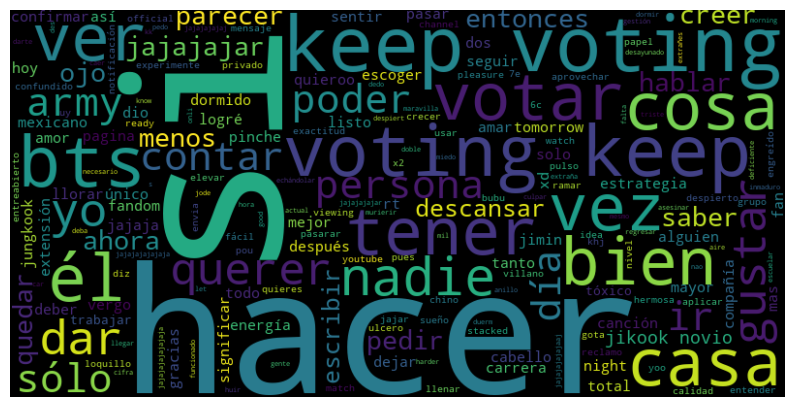

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convertir la lista de tokens lematizados en un solo texto
text_lemmatized = ' '.join(all_lemmatized_tokens)

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text_lemmatized)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()



#### 6. Extracción de palabras importantes

Para alcanzar el objetivo número 1, vamos a crear un algoritmo que determine la unicidad de una palabra dentro de la lista de tokens limpios. El objetivo es buscar palabras que tengan una frecuencia mayor en cada tuit pero que no esten en otros tuits. Ese tipo de palabras en ciertos contextos son útiles para representar oraciones entre otras cosas.

Ejemplo de unicidad con valor de 1.0

Imagina que tienes tres oraciones:

    "El rápido zorro marrón salta sobre el perro perezoso."
    "Los niños juegan en el parque durante el día."
    "La lluvia en España cae principalmente en la llanura."

Si analizamos la palabra "España", y solo aparece en la tercera oración y en ninguna otra, entonces su unicidad sería de 1.0 para esa oración.

In [22]:
## No modificar este código
def calcular_unicidad(oraciones):
    frecuencia_total = {}
    frecuencia_oracion = [{} for _ in oraciones]

    # Calcular frecuencias básicas
    for index, oracion in enumerate(oraciones):
        palabras = oracion.split()
        for palabra in palabras:
            frecuencia_total[palabra] = frecuencia_total.get(palabra, 0) + 1
            if palabra in frecuencia_oracion[index]:
                frecuencia_oracion[index][palabra] += 1
            else:
                frecuencia_oracion[index][palabra] = 1

    # Calcular la métrica de unicidad para cada palabra en cada oración
    unicidad_simple = []
    for frec in frecuencia_oracion:
        doc_unicidad = {}
        for palabra, count in frec.items():
            doc_unicidad[palabra] = count / frecuencia_total[palabra]
        unicidad_simple.append(doc_unicidad)

    return unicidad_simple


In [23]:
## No modificar este código
oraciones = texts_df.cleaned_tokens.apply(lambda x: ' '.join(x)).values
unicidad_simple = calcular_unicidad(oraciones)

unicidad_simple

[{'después': 0.5,
  'dices': 1.0,
  'no': 0.03571428571428571,
  'fan': 0.5,
  '..': 0.25},
 {'jajajaja': 0.3333333333333333,
  'si': 0.08333333333333333,
  'deja': 1.0,
  'crecer': 1.0,
  'cabello': 1.0,
  'bien': 0.2,
  'gusta': 0.25,
  'idea': 1.0,
  '100': 1.0,
  '%': 1.0,
  '?': 0.08333333333333333,
  'veces': 0.3333333333333333,
  'usaba': 1.0,
  'extensiones': 0.5},
 {'tener': 0.2,
  'pulso': 1.0,
  'nivel': 1.0,
  '500': 1.0,
  'darle': 1.0,
  'exactitud': 1.0,
  ',': 0.06382978723404255,
  'parece': 1.0,
  'fácil': 1.0,
  'no': 0.03571428571428571,
  'experimente': 1.0,
  'engreído': 1.0,
  'casa': 0.2,
  'hizo': 1.0,
  'ulcera': 1.0,
  'parecer': 0.5,
  'rama': 1.0,
  'solo': 0.5,
  '1': 1.0,
  'vez': 0.5,
  'logré': 0.5,
  'aplicarle': 1.0,
  'gota': 1.0,
  'despierto': 1.0,
  'aprovechaba': 1.0,
  'dormido': 1.0,
  'ojo': 0.5,
  'entreabierto': 1.0},
 {'chino': 1.0, 'mas': 0.5, '?': 0.08333333333333333, '!': 0.25},
 {'extensiones': 0.5},
 {'calidad': 1.0, 'xd': 0.5},
 {'x2'

In [24]:
## No modificar este código
for i, doc_unicidad in enumerate(unicidad_simple):
    print(f"Tuit {i + 1}:")
    try:
      #en caso de existir varias seleccionar la primera
      max_word = max(doc_unicidad, key=doc_unicidad.get)  # Encuentra la palabra con la unicidad más alta
      print(f"  Palabra más representativa: {max_word} con unicidad de {doc_unicidad[max_word]:.2f}")
    except:
      pass

Tuit 1:
  Palabra más representativa: dices con unicidad de 1.00
Tuit 2:
  Palabra más representativa: deja con unicidad de 1.00
Tuit 3:
  Palabra más representativa: pulso con unicidad de 1.00
Tuit 4:
  Palabra más representativa: chino con unicidad de 1.00
Tuit 5:
  Palabra más representativa: extensiones con unicidad de 0.50
Tuit 6:
  Palabra más representativa: calidad con unicidad de 1.00
Tuit 7:
  Palabra más representativa: x2 con unicidad de 1.00
Tuit 8:
  Palabra más representativa: pou con unicidad de 1.00
Tuit 9:
  Palabra más representativa: eleven con unicidad de 1.00
Tuit 10:
  Palabra más representativa: pues con unicidad de 1.00
Tuit 11:
  Palabra más representativa: quieres con unicidad de 1.00
Tuit 12:
  Palabra más representativa: yoo con unicidad de 1.00
Tuit 13:
  Palabra más representativa: hermosas con unicidad de 1.00
Tuit 14:
  Palabra más representativa: #btswins10s con unicidad de 0.06
Tuit 15:
  Palabra más representativa: sueños con unicidad de 1.00
Tuit 16

#### 7. Encontrar Bigrams y Trigrams más comúnes.

Usando `NLTK` calcula los bigrams y trigrams para cada lista de tokens limpios y guardalos en columnas nuevas.

Después encuentra el brigram y trigram más común.

In [28]:
# Función para obtener los bigrams y trigrams más comunes de una lista de tokens limpios
def obtener_bigrams_trigrams_mas_comunes(tokens_limpios):
    # Obtener bigrams y trigrams
    bigrams_lista = list(bigrams(tokens_limpios))
    trigrams_lista = list(trigrams(tokens_limpios))
    
    # Calcular la frecuencia de cada bigram y trigram
    frecuencia_bigrams = FreqDist(bigrams_lista)
    frecuencia_trigrams = FreqDist(trigrams_lista)
    
    # Obtener los bigrams y trigrams más comunes
    bigram_mas_comun = frecuencia_bigrams.most_common(1)
    trigram_mas_comun = frecuencia_trigrams.most_common(1)
    
    return bigram_mas_comun, trigram_mas_comun

# Aplicar la función a cada lista de tokens limpios y guardar los resultados en columnas nuevas
texts_df['bigrams'], texts_df['trigrams'] = zip(*texts_df['cleaned_tokens'].apply(obtener_bigrams_trigrams_mas_comunes))

# Mostrar los resultados
texts_df


,tuits,cleaned_tuits,tokens,cleaned_tokens,lemmatized_tokens,bigrams_comunes,trigrams_comunes,bigrams,trigrams
0,@Liz_Mile Y después dices que no eres fan... h...,y después dices que no eres fan..,"[y, después, dices, que, no, eres, fan, ..]","[después, dices, no, fan, ..]","[después, diz, no, fan, ..]","[((después, dices), 1)]","[((después, dices, no), 1)]","[((después, dices), 1)]","[((después, dices, no), 1)]"
1,@Liz_Mile @Yaniserrano @ChasKapop Jajajaja si ...,jajajaja si se deja crecer el cabello estaría ...,"[jajajaja, si, se, deja, crecer, el, cabello, ...","[jajajaja, si, deja, crecer, cabello, bien, gu...","[jajajajar, si, dejar, crecer, cabello, bien, ...","[((jajajaja, si), 1)]","[((jajajaja, si, deja), 1)]","[((jajajaja, si), 1)]","[((jajajaja, si, deja), 1)]"
2,Hay que tener pulso nivel 500 para darle con e...,hay que tener pulso nivel 500 para darle con e...,"[hay, que, tener, pulso, nivel, 500, para, dar...","[tener, pulso, nivel, 500, darle, exactitud, ,...","[tener, pulso, nivel, 500, dar él, exactitud, ...","[((tener, pulso), 1)]","[((tener, pulso, nivel), 1)]","[((tener, pulso), 1)]","[((tener, pulso, nivel), 1)]"
3,@Liz_Mile Otro chino mas?!!!!! https://t.co/Ls...,otro chino mas?!!,"[otro, chino, mas, ?, !, !]","[chino, mas, ?, !, !]","[chino, mas, ?, !, !]","[((chino, mas), 1)]","[((chino, mas, ?), 1)]","[((chino, mas), 1)]","[((chino, mas, ?), 1)]"
4,@Yaniserrano Más extensiones 🤣,más extensiones,"[más, extensiones]",[extensiones],[extensión],[],[],[],[]
...,...,...,...,...,...,...,...,...,...
95,Sera que se tomaron la foto alli cuando los ch...,sera que se tomaron la foto alli cuando los ch...,"[sera, que, se, tomaron, la, foto, alli, cuand...","[sera, tomaron, foto, alli, chicos, grabando, ...","[sero, tomar, foto, alli, chico, grabar, progr...","[((sera, tomaron), 1)]","[((sera, tomaron, foto), 1)]","[((sera, tomaron), 1)]","[((sera, tomaron, foto), 1)]"
96,"Fluir bien, hacer las cosas lo mejor que se pu...","fluir bien, hacer las cosas lo mejor que se pu...","[fluir, bien, ,, hacer, las, cosas, lo, mejor,...","[fluir, bien, ,, hacer, cosas, mejor, pueda, h...","[fluir, bien, ,, hacer, cosa, mejor, poder, ha...","[((fluir, bien), 1)]","[((fluir, bien, ,), 1)]","[((fluir, bien), 1)]","[((fluir, bien, ,), 1)]"
97,No les enseñaron que lo mínimo es saludar y da...,no les enseñaron que lo mínimo es saludar y da...,"[no, les, enseñaron, que, lo, mínimo, es, salu...","[no, enseñaron, mínimo, saludar, dar, gracias,...","[no, enseñar, mínimo, saludar, dar, gracias, ?...","[((no, enseñaron), 1)]","[((no, enseñaron, mínimo), 1)]","[((no, enseñaron), 1)]","[((no, enseñaron, mínimo), 1)]"
98,Dice que me superó pero crea perfiles falsos e...,dice que me superó pero crea perfiles falsos e...,"[dice, que, me, superó, pero, crea, perfiles, ...","[dice, superó, crea, perfiles, falsos, grindr,...","[decir, superar, creer, perfil, falso, grindr,...","[((dice, superó), 1)]","[((dice, superó, crea), 1)]","[((dice, superó), 1)]","[((dice, superó, crea), 1)]"


### Bigrams

In [32]:
# Imprimir solo la columna 'bigrams_comunes'
for bigrams_comunes in texts_df['bigrams']:
    for bigram, frecuencia in bigrams_comunes:
        print(f"({bigram}, {frecuencia}),")
    print()



(('después', 'dices'), 1),

(('jajajaja', 'si'), 1),

(('tener', 'pulso'), 1),

(('chino', 'mas'), 1),


(('calidad', 'xd'), 1),

(('x2', 'khj'), 1),

(('pou', 'loquillo'), 1),

(('tomorrow', 'night'), 2),

(('pues', 'sentiría'), 1),

(('si', 'quieres'), 1),

(('yoo', 'bubu'), 1),



(('sueños', '#btswins10s'), 1),

(('jaja', '#btswins10s'), 1),

(('uy', ','), 1),

(('jajajajajajaja', '#btswins10s'), 1),

(('jajajajajajajaja', '#btswins10s'), 1),

(('jajajajajaj', '#btswins10s'), 1),

(('jajajajajajaaj', '#btswins10'), 1),

(('kk', 'nao'), 1),

(('jajajajaja', '?'), 1),

(('ahora', 'gente'), 1),

(('good', 'morning'), 1),

(('keep', 'voting'), 7),

(('#lopezestasbienpendejo', '#lopezgenocida'), 1),

(('miedo', 'jode'), 1),

(('si', 'estrategia'), 2),

(('tener', 'poder'), 1),

(('pasó', '?'), 1),

(('sólo', 'extrañes'), 1),


(('hueva', ','), 1),

(('triste', 'darte'), 1),

(('pedo', 'gusta'), 1),

(('único', 'queda'), 1),


(('no', 'mames'), 1),


(('"', 'disfruta'), 1),

(('no', 'log

### Trigrams

In [34]:
# Imprimir solo la columna 'trigrams_comunes'
for trigrams_comunes in texts_df['trigrams']:
    for trigram, frecuencia in trigrams_comunes:
        print(f"({trigram}, {frecuencia}),")
    print()


(('después', 'dices', 'no'), 1),

(('jajajaja', 'si', 'deja'), 1),

(('tener', 'pulso', 'nivel'), 1),

(('chino', 'mas', '?'), 1),



(('x2', 'khj', 'debe'), 1),

(('pou', 'loquillo', 'xd'), 1),

(('eleven', 'stacked', 'matches'), 1),

(('pues', 'sentiría', 'confundido'), 1),

(('si', 'quieres', 'hacerme'), 1),

(('yoo', 'bubu', 'quiero'), 1),





(('uy', ',', 'si'), 1),





(('kk', 'nao', 'mesmo'), 1),

(('jajajajaja', '?', 'army'), 1),

(('ahora', 'gente', 'llegué'), 1),

(('good', 'morning', 'to'), 1),

(('keep', 'voting', 'keep'), 6),

(('#lopezestasbienpendejo', '#lopezgenocida', '#lopezcorruptoinepto'), 1),

(('miedo', 'jode', ','), 1),

(('si', 'estrategia', 'murieran'), 1),

(('tener', 'poder', 'asesinar'), 1),


(('sólo', 'extrañes', 'alguien'), 1),


(('hueva', ',', 'mayor'), 1),

(('triste', 'darte', 'cuenta'), 1),

(('pedo', 'gusta', 'crush'), 1),

(('único', 'queda', 'claro'), 1),




(('"', 'disfruta', 'soledad'), 1),

(('no', 'logré', ','), 1),


(('hablan', 'extrañan'

## ¿Qué otras funciones de limpieza o análisis aplicarías y porqué?
Stemming: El stemming es el proceso de eliminar sufijos y prefijos de las palabras para quedarse con la raíz. Por ejemplo, convertir "corriendo", "correrá" y "correría" a la raíz "correr". Esto puede reducir la dimensionalidad del texto y agrupar palabras relacionadas.

In [36]:
from nltk.stem import SnowballStemmer

# Inicializar el stemmer
stemmer = SnowballStemmer('spanish')

# Función para aplicar stemming a una lista de tokens
def aplicar_stemming(tokens):
    return [stemmer.stem(token) for token in tokens]

# Aplicar stemming a la columna 'cleaned_tokens' y guardar los resultados en una nueva columna 'stemmed_tokens'
texts_df['stemmed_tokens'] = texts_df['cleaned_tokens'].apply(aplicar_stemming)

# Mostrar el DataFrame resultante
texts_df


,tuits,cleaned_tuits,tokens,cleaned_tokens,lemmatized_tokens,bigrams,trigrams,stemmed_tokens
0,@Liz_Mile Y después dices que no eres fan... h...,y después dices que no eres fan..,"[y, después, dices, que, no, eres, fan, ..]","[después, dices, no, fan, ..]","[después, diz, no, fan, ..]","[((después, dices), 1)]","[((después, dices, no), 1)]","[despues, dic, no, fan, ..]"
1,@Liz_Mile @Yaniserrano @ChasKapop Jajajaja si ...,jajajaja si se deja crecer el cabello estaría ...,"[jajajaja, si, se, deja, crecer, el, cabello, ...","[jajajaja, si, deja, crecer, cabello, bien, gu...","[jajajajar, si, dejar, crecer, cabello, bien, ...","[((jajajaja, si), 1)]","[((jajajaja, si, deja), 1)]","[jajajaj, si, dej, crec, cabell, bien, gust, i..."
2,Hay que tener pulso nivel 500 para darle con e...,hay que tener pulso nivel 500 para darle con e...,"[hay, que, tener, pulso, nivel, 500, para, dar...","[tener, pulso, nivel, 500, darle, exactitud, ,...","[tener, pulso, nivel, 500, dar él, exactitud, ...","[((tener, pulso), 1)]","[((tener, pulso, nivel), 1)]","[ten, puls, nivel, 500, darl, exactitud, ,, pa..."
3,@Liz_Mile Otro chino mas?!!!!! https://t.co/Ls...,otro chino mas?!!,"[otro, chino, mas, ?, !, !]","[chino, mas, ?, !, !]","[chino, mas, ?, !, !]","[((chino, mas), 1)]","[((chino, mas, ?), 1)]","[chin, mas, ?, !, !]"
4,@Yaniserrano Más extensiones 🤣,más extensiones,"[más, extensiones]",[extensiones],[extensión],[],[],[extension]
...,...,...,...,...,...,...,...,...
95,Sera que se tomaron la foto alli cuando los ch...,sera que se tomaron la foto alli cuando los ch...,"[sera, que, se, tomaron, la, foto, alli, cuand...","[sera, tomaron, foto, alli, chicos, grabando, ...","[sero, tomar, foto, alli, chico, grabar, progr...","[((sera, tomaron), 1)]","[((sera, tomaron, foto), 1)]","[ser, tom, fot, alli, chic, grab, program, "", ..."
96,"Fluir bien, hacer las cosas lo mejor que se pu...","fluir bien, hacer las cosas lo mejor que se pu...","[fluir, bien, ,, hacer, las, cosas, lo, mejor,...","[fluir, bien, ,, hacer, cosas, mejor, pueda, h...","[fluir, bien, ,, hacer, cosa, mejor, poder, ha...","[((fluir, bien), 1)]","[((fluir, bien, ,), 1)]","[flu, bien, ,, hac, cos, mejor, pued, hac, dañ..."
97,No les enseñaron que lo mínimo es saludar y da...,no les enseñaron que lo mínimo es saludar y da...,"[no, les, enseñaron, que, lo, mínimo, es, salu...","[no, enseñaron, mínimo, saludar, dar, gracias,...","[no, enseñar, mínimo, saludar, dar, gracias, ?...","[((no, enseñaron), 1)]","[((no, enseñaron, mínimo), 1)]","[no, enseñ, minim, salud, dar, graci, ?, gas, ..]"
98,Dice que me superó pero crea perfiles falsos e...,dice que me superó pero crea perfiles falsos e...,"[dice, que, me, superó, pero, crea, perfiles, ...","[dice, superó, crea, perfiles, falsos, grindr,...","[decir, superar, creer, perfil, falso, grindr,...","[((dice, superó), 1)]","[((dice, superó, crea), 1)]","[dic, super, cre, perfil, fals, grindr, escrib..."


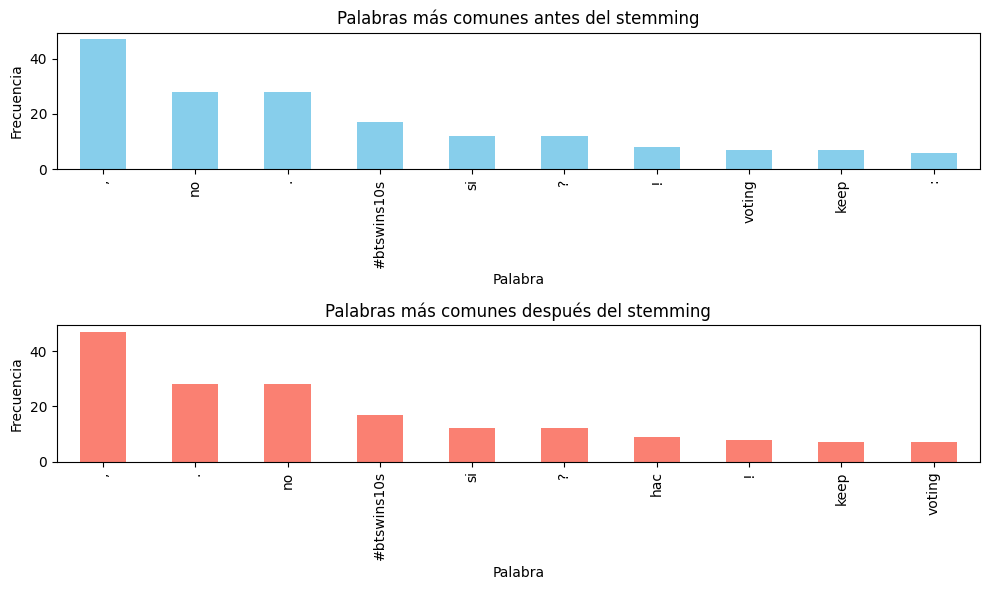

In [37]:
# Obtener las frecuencias de las palabras antes y después de aplicar stemming
frecuencia_palabras_original = texts_df['cleaned_tokens'].explode().value_counts().head(10)
frecuencia_palabras_stemmed = texts_df['stemmed_tokens'].explode().value_counts().head(10)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
frecuencia_palabras_original.plot(kind='bar', color='skyblue')
plt.title('Palabras más comunes antes del stemming')
plt.xlabel('Palabra')
plt.ylabel('Frecuencia')

plt.subplot(2, 1, 2)
frecuencia_palabras_stemmed.plot(kind='bar', color='salmon')
plt.title('Palabras más comunes después del stemming')
plt.xlabel('Palabra')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()
